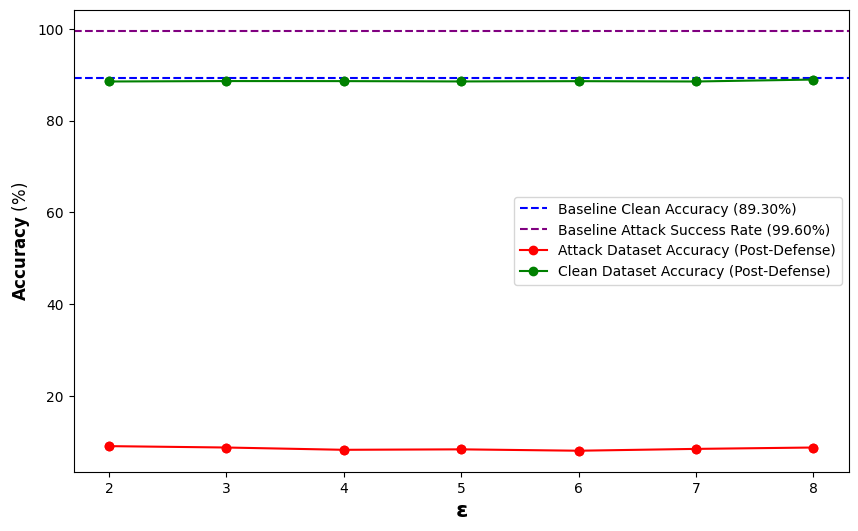

In [24]:
############CONV CIFAR############

import matplotlib.pyplot as plt

# Data
epsilon = [2, 3, 4, 5, 6, 7, 8]
attack_accuracy = [9.01, 8.71, 8.21, 8.31, 8.01, 8.41, 8.71]
clean_accuracy = [88.53, 88.62, 88.61, 88.54, 88.60, 88.53, 88.95]
base_accuracy = 89.30
attack_before_defense = 99.60

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(y=base_accuracy, color='blue', linestyle='--', label='Baseline Clean Accuracy (89.30%)')
plt.axhline(y=attack_before_defense, color='purple', linestyle='--', label='Baseline Attack Success Rate (99.60%)')
plt.plot(epsilon, attack_accuracy, marker='o', color='red', label='Attack Dataset Accuracy (Post-Defense)', linestyle='-')
plt.plot(epsilon, clean_accuracy, marker='o', color='green', label='Clean Dataset Accuracy (Post-Defense)', linestyle='-')
plt.scatter(epsilon, attack_accuracy, color='red')
plt.scatter(epsilon, clean_accuracy, color='green')

# Labels and legend
plt.xlabel(r'$\bf{\epsilon}$', fontsize=16)
plt.ylabel(r'$\bf{Accuracy}$ (%)', fontsize=12)
plt.legend()

# Save and show plot
plt.savefig('ConvCifPlot.png', dpi=300, bbox_inches='tight')
plt.show()